# Data Cleaning

In [14]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Load Datasets

In [15]:
#Source file: https://www.kaggle.com/usdot/flight-delays#flights.csv

#Main dataset
df_delayed_flights = pd.read_csv('data/flights.csv', low_memory=False)

#Complementary datasets
df_airports = pd.read_csv('data/airports.csv', low_memory=False)
df_airlines = pd.read_csv('data/airlines.csv', low_memory=False)

## 2. Summarize the data

In [ ]:
print('------- Main Dataset, Flights -------')
print(df_delayed_flights.shape)
print(df_delayed_flights.columns)
print(df_delayed_flights.head())
print(df_delayed_flights.describe())

print('\n ------- Airports -------')
print(df_airports.shape)
print(df_airports.columns)
print(df_airports.head())
print(df_airports.describe())

print('\n ------- Airlines -------')
print(df_airlines.shape)
print(df_airlines.columns)
print(df_airlines.head())
print(df_airlines.describe())

## 3. Data Cleaning

### 3.1. Missing values

In [17]:
print("Delayed Flights Missing Values:\n", df_delayed_flights.isnull().sum())
print("Airlines Missing Values:\n", df_airlines.isnull().sum())
print("Airports Missing Values:\n", df_airports.isnull().sum())

Delayed Flights Missing Values:
 YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype:

### Missing Values: CANCELLATION_REASON

In [19]:
print("Total number of flights: ", len(df_delayed_flights))
print("Cancelled flights= ", sum(df_delayed_flights['CANCELLED']))
print("Flights with calcelation reason = ", sum(df_delayed_flights['CANCELLATION_REASON'] != np.nan))

Total number of flights:  5819079
Cancelled flights=  89884
Flights with calcelation reason =  5819079


#### Conclusion: Number of missing data in CANCELLATION_REASON is large, because when the flight was not cancelled, no value was added.

In [ ]:
#We can fill the missing value with a new defined value `NC` = Not Cancelled

#df_delayed_flights['CANCELLATION_REASON'] = df_delayed_flights['CANCELLATION_REASON'].fillna('NC')
#df_delayed_flights['CANCELLATION_REASON'].isnull().sum()
#print(df_delayed_flights['CANCELLATION_REASON'][df_delayed_flights['CANCELLATION_REASON'] != 'NC'])

### 3.2. Merge Columns - DATE

In [36]:
df_delayed_flights['DATE'] = pd.to_datetime(df_delayed_flights[['YEAR','MONTH', 'DAY']])
print(df_delayed_flights.columns)

Index(['DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON',
       'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE'],
      dtype='object')


### 3.3. Remove not relevant and duplicated columns

In [37]:
df_delayed_flights = df_delayed_flights.drop(['YEAR','MONTH', 'DAY'], axis=1)
print(df_delayed_flights.columns)

df_airports = df_airports[['IATA_CODE','AIRPORT']]
print(df_airports.columns)

KeyError: "['YEAR' 'MONTH' 'DAY'] not found in axis"

### 3.4. Change type

In [42]:
# Function to convert from 'HHMM' string to datetime.time
# Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

import datetime

def format_time(time_string):
    
    if ~(isinstance(time_string, str)):
        return time_string
    
    if pd.isnull(time_string):
        return np.nan
    
    else:
        if time_string == 2400: #12 midnight
            time_string = 0
            
        time_string = "{0:04d}".format(int(time_string)) #Format the string to be as 4 decimals (hh:mm)
        formated_time = datetime.time(int(time_string[0:2]), int(time_string[2:4])) #Split the 4 digits into 2 parts
        return formated_time

In [43]:
# Call the Function:

df_delayed_flights['SCHEDULED_DEPARTURE'] = df_delayed_flights['SCHEDULED_DEPARTURE'].apply(format_time)
df_delayed_flights['DEPARTURE_TIME'] = df_delayed_flights['DEPARTURE_TIME'].apply(format_time)
df_delayed_flights['SCHEDULED_ARRIVAL'] =df_delayed_flights['SCHEDULED_ARRIVAL'].apply(format_time)
df_delayed_flights['ARRIVAL_TIME'] = df_delayed_flights['ARRIVAL_TIME'].apply(format_time)

df_delayed_flights.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
                            'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,00:05:00,04:30:00,23:54:00,04:08:00,-11.00,-22.00
1,00:10:00,07:50:00,00:02:00,07:41:00,-8.00,-9.00
2,00:20:00,08:06:00,00:18:00,08:11:00,-2.00,5.00
3,00:20:00,08:05:00,00:15:00,07:56:00,-5.00,-9.00
4,00:25:00,03:20:00,00:24:00,02:59:00,-1.00,-21.00
5,00:25:00,06:02:00,00:20:00,06:10:00,-5.00,8.00


## 4. Removing Outliers

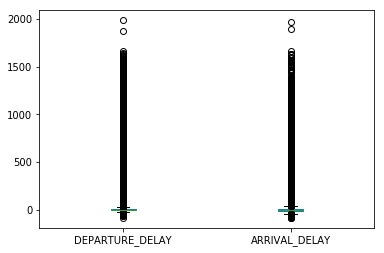

In [30]:
df_delayed_flights[["DEPARTURE_DELAY","ARRIVAL_DELAY"]].plot.box()
plt.show()

TypeError: '<=' not supported between instances of 'int' and 'str'

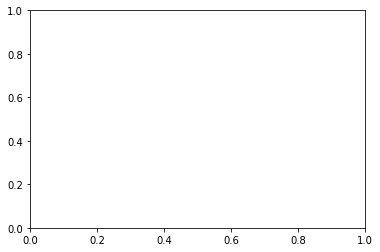

In [50]:
# Excessive Arrival Delays 
plt.hist(df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] != 0.00], bins=100)
plt.show()


#print(df_delayed_flights['ARRIVAL_DELAY'].value_counts())
print('mean', np.mean(df_delayed_flights['ARRIVAL_DELAY'] != 0))
print('std', np.std(df_delayed_flights['ARRIVAL_DELAY'] != 0))


#Must remove 0.00 from average and STD TCE

In [ ]:
df_merge['ARRIVAL_DELAY'] = df_merge['ARRIVAL_DELAY'].replace('0.00', np.nan)
#This needs work - Unable to remove 0.00 values TCE

avg_delay = sum(df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] != 0]) / len(df_delayed_flights['ARRIVAL_DELAY'] != 0)
print("Avg Arrival Delay =",avg_delay)


## 5. Merging datasets

In [ ]:
df_merge_v1 = df_delayed_flights.copy()

#Merge Airlines and Flights dfs
df_merge_v1 = pd.merge(df_delayed_flights, df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')

df_merge_v1.drop('IATA_CODE', axis=1, inplace=True)
df_merge_v1.rename(columns={'AIRLINE_x': 'AIRLINE_CODE','AIRLINE_y': 'AIRLINE'}, inplace=True)

In [ ]:
print("Merged Dataframe Columns: \n", df_merge_v1.columns)
print(df_merge_v1)

## Save file

In [ ]:
df_merge.to_csv('data/flightsmerged.csv', index=False)